In [21]:
from src import data_prep
import importlib
import numpy as np
import pandas as pd
import os
import gc

from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import seaborn as sns

importlib.reload(data_prep)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
app_train = pd.read_csv('../data/home-credit-default-risk/application_train.csv')
app_test = pd.read_csv('../data/home-credit-default-risk/application_test.csv')
app_test.describe()
app_train.describe()
app_train['TARGET'].value_counts()


TARGET
0    282686
1     24825
Name: count, dtype: int64

In [23]:
from src.data_prep import load_and_aggregate_table
tables_annexes = [
    ('bureau.csv', 'bureau'),
    ('previous_application.csv', 'previous_application'),
    ('installments_payments.csv', 'installments_payments'),
    ('credit_card_balance.csv', 'credit_card_balance'),
    ('POS_CASH_balance.csv', 'POS_CASH_balance')
]

for filename, table_name in tables_annexes:
    file_path = os.path.join('../data/home-credit-default-risk', filename)

    print(f"\nTraitement de {table_name}...")

    agg_df = load_and_aggregate_table(file_path, table_name)
    print(f"-> Résultat agrégé : {agg_df.shape[0]} clients, {agg_df.shape[1]} nouvelles colonnes.")

    #Fusion (Left Join sur SK_ID_CURR)
    app_train = app_train.merge(agg_df, on='SK_ID_CURR', how='left')
    app_test = app_test.merge(agg_df, on='SK_ID_CURR', how='left')

    del agg_df
    gc.collect()


# Remplissage des NaN créés par les fusions (0 = pas d'historique)
# On remplit toutes les colonnes numériques sauf TARGET et ID
cols_to_fill = [c for c in app_train.columns if c not in ['TARGET', 'SK_ID_CURR']]
app_train[cols_to_fill] = app_train[cols_to_fill].fillna(0)
app_test[cols_to_fill] = app_test[cols_to_fill].fillna(0)


Traitement de bureau...
Usage mémoire initial du DataFrame: 58.33 MB
Usage mémoire final du DataFrame: 23.04 MB
Mémoire réduite de 60.5 %
-> Résultat agrégé : 305811 clients, 24 nouvelles colonnes.

Traitement de previous_application...
Usage mémoire initial du DataFrame: 43.95 MB
Usage mémoire final du DataFrame: 21.33 MB
Mémoire réduite de 51.5 %
-> Résultat agrégé : 338857 clients, 16 nouvelles colonnes.

Traitement de installments_payments...
Usage mémoire initial du DataFrame: 54.41 MB
Usage mémoire final du DataFrame: 22.02 MB
Mémoire réduite de 59.5 %
-> Résultat agrégé : 339587 clients, 20 nouvelles colonnes.

Traitement de credit_card_balance...
Usage mémoire initial du DataFrame: 26.07 MB
Usage mémoire final du DataFrame: 11.26 MB
Mémoire réduite de 56.8 %
-> Résultat agrégé : 103558 clients, 32 nouvelles colonnes.

Traitement de POS_CASH_balance...
Usage mémoire initial du DataFrame: 54.03 MB
Usage mémoire final du DataFrame: 16.08 MB
Mémoire réduite de 70.2 %
-> Résultat a

In [24]:
from src.data_prep import missing_values_table

missing_values = missing_values_table(app_test)
missing_values.head(20)


Your selected dataframe has 233 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Ratio de la classe majoritaire (0) : 91.93%
Ratio de la classe minoritaire (1) : 8.07%


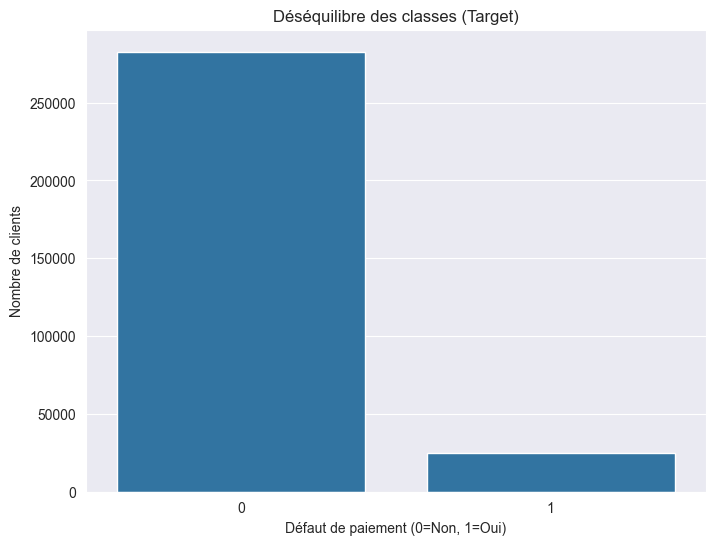

In [25]:
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=app_train)
plt.title('Déséquilibre des classes (Target)')
plt.xlabel('Défaut de paiement (0=Non, 1=Oui)')
plt.ylabel('Nombre de clients')

ratio = app_train['TARGET'].value_counts(normalize=True)
print(f"Ratio de la classe majoritaire (0) : {ratio[0]:.2%}")
print(f"Ratio de la classe minoritaire (1) : {ratio[1]:.2%}")
plt.show()

In [26]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

3 columns were label encoded.


In [27]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

In [28]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

C:\Users\jevsez\AppData\Local\Temp\ipykernel_28696\2063607089.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
C:\Users\jevsez\AppData\Local\Temp\ipykernel_28696\2063607089.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

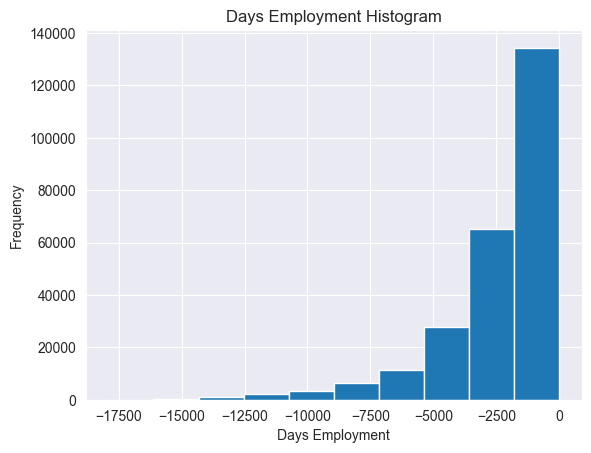

In [29]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

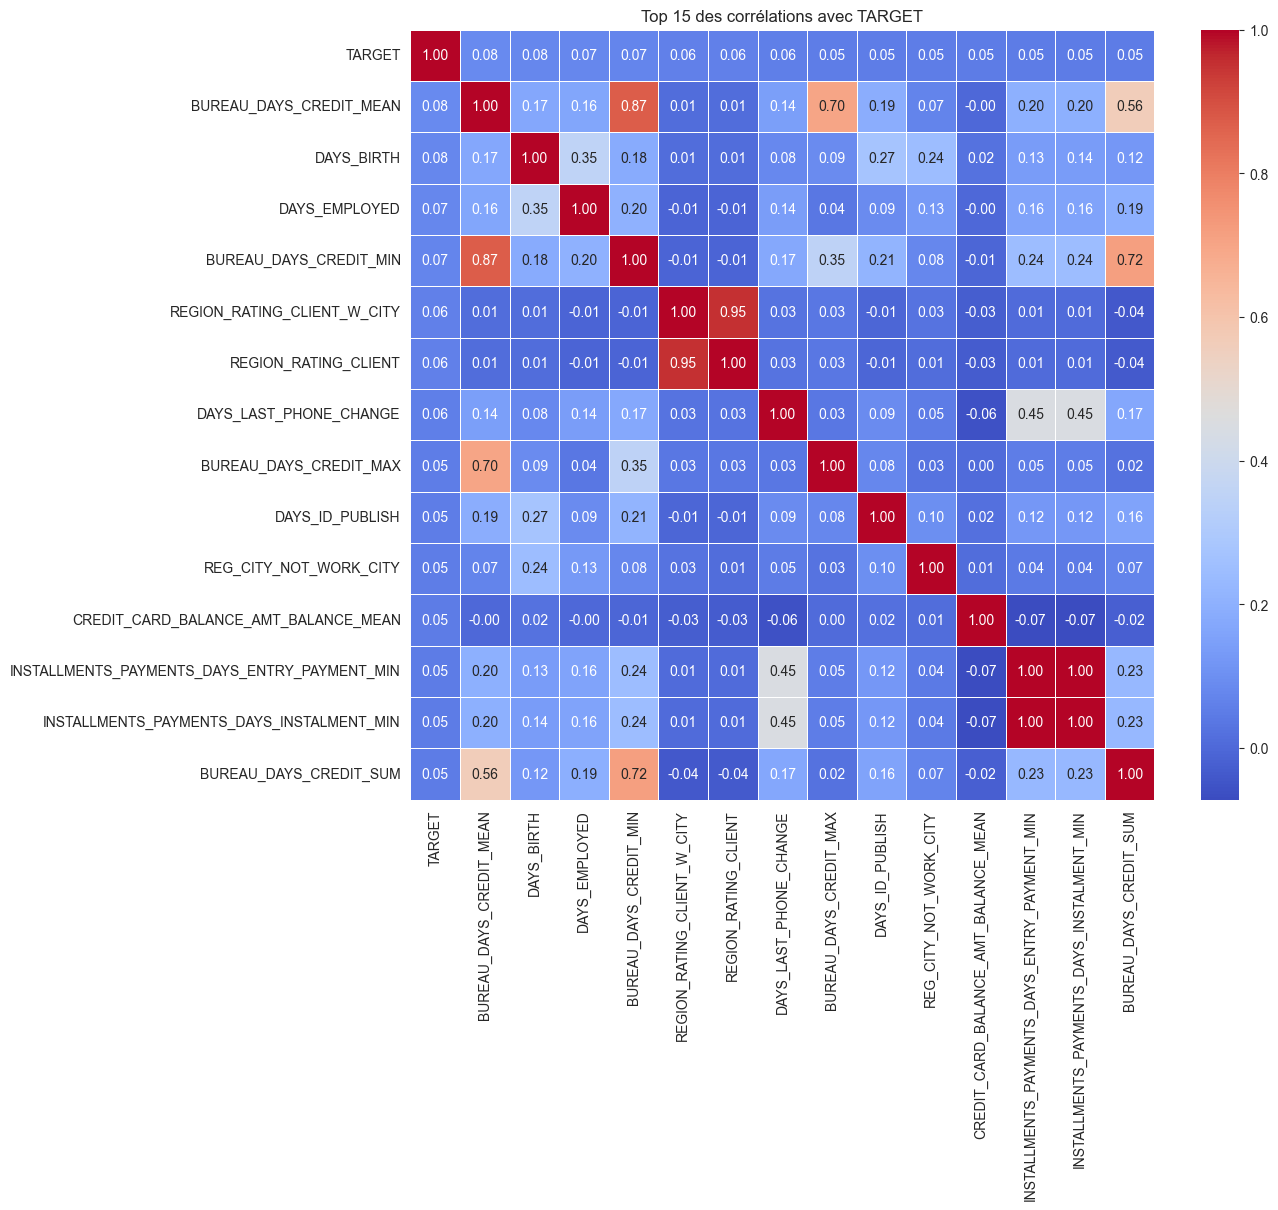

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = app_train.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()

cols_to_plot = corr_matrix.nlargest(15, 'TARGET')['TARGET'].index
correlation_subset = numeric_df[cols_to_plot].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_subset,
            annot=True,        # Afficher les valeurs
            cmap="coolwarm",   # Couleurs du bleu (froid) au rouge (chaud)
            fmt=".2f",         # 2 décimales
            linewidths=0.5)
plt.title("Top 15 des corrélations avec TARGET")
plt.show()

In [31]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

np.float64(-0.07823930830982709)

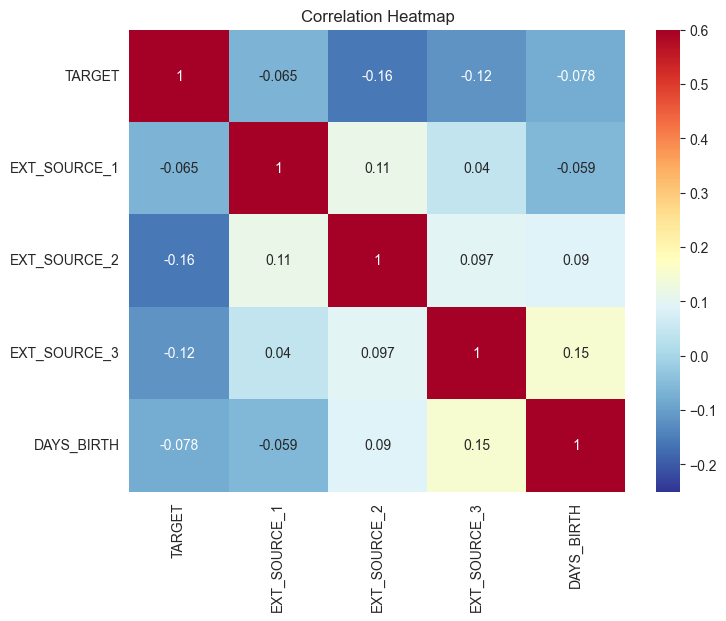

In [32]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
plt.figure(figsize = (8, 6))

sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');


In [33]:
from src.data_prep import create_domain_features

app_train = create_domain_features(app_train)
app_test = create_domain_features(app_test)

print("Features métier créées.")

Features métier créées.


In [34]:
import re
from src.data_prep import reduce_mem_usage

# Nettoyage des caractères spéciaux dans les noms de colonnes pour LightGBM/XGBoost
app_train = app_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
app_test = app_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

app_train = reduce_mem_usage(app_train)
app_test = reduce_mem_usage(app_test)

import os
os.makedirs('../data/processed', exist_ok=True)
app_train.to_csv('../data/processed/train_final.csv')
app_test.to_csv('../data/processed/test_final.csv', index=False)
print("Fichiers sauvegardés avec succès !")

Usage mémoire initial du DataFrame: 459.25 MB
Usage mémoire final du DataFrame: 198.83 MB
Mémoire réduite de 56.7 %
Usage mémoire initial du DataFrame: 72.43 MB
Usage mémoire final du DataFrame: 31.47 MB
Mémoire réduite de 56.5 %
Fichiers sauvegardés avec succès !
